<center><h1>Kaggle House Prices Prediction with XGBoost</h1></center>

This notebook is my submission for the Kaggle House Prices: Advanced Regression Techniques competition. The goal is to predict house prices using the provided dataset, which includes features like square footage, neighborhood, and overall quality. I used XGBoost, a gradient boosting model, to achieve an RMSLE of 0.12946 on the test set, with preprocessing, feature engineering, and cross-validation to improve performance.

You can find the competition details and dataset on Kaggle: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).

## Data Loading and Setup
In this section, we load the training and test datasets from the Kaggle competition and set up the necessary libraries for analysis and modeling.

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Save test IDs for submission
test_ids = test['Id']

# Display basic information about the datasets
print("Train dataset shape:", train.shape)
print("Test dataset shape:", test.shape)


Train dataset shape: (1460, 81)
Test dataset shape: (1459, 80)


In [18]:
train_info = pd.DataFrame({
    'Column Name': train.columns,
    'Data Type': train.dtypes.values,
    'Non-Null Count (Train)': train.notnull().sum().values
})
test_info = pd.DataFrame({
    'Column Name': test.columns,
    'Non-Null Count (Test)': test.notnull().sum().values
})

# Merge the two DataFrames on Column Name
info_table = train_info.merge(test_info, on='Column Name', how='outer')

In [19]:
print("\nSummary of Key Columns:\n")
print(info_table.to_markdown())


Summary of Key Columns:

|    | Column Name   | Data Type   |   Non-Null Count (Train) |   Non-Null Count (Test) |
|---:|:--------------|:------------|-------------------------:|------------------------:|
|  0 | Id            | int64       |                     1460 |                    1459 |
|  1 | MSSubClass    | int64       |                     1460 |                    1459 |
|  2 | MSZoning      | object      |                     1460 |                    1455 |
|  3 | LotFrontage   | float64     |                     1201 |                    1232 |
|  4 | LotArea       | int64       |                     1460 |                    1459 |
|  5 | Street        | object      |                     1460 |                    1459 |
|  6 | Alley         | object      |                       91 |                     107 |
|  7 | LotShape      | object      |                     1460 |                    1459 |
|  8 | LandContour   | object      |                     1460 |           

## Data Exploration and Analysis
Before preprocessing, we explore the dataset to understand its characteristics and identify patterns that will inform our modeling decisions. This section includes visualizations of the target variable (`SalePrice`), its distribution, and its relationship with key features. We plot the distribution of `SalePrice`, its correlation with numerical features (correlation > 0.5), and its relationship with `OverallQual` and `GrLivArea`. These insights help justify steps like log-transformation and outlier removal. Note that engineered features like `TotalSF` (total square footage) will be created later during feature engineering and are also highly correlated with `SalePrice`.

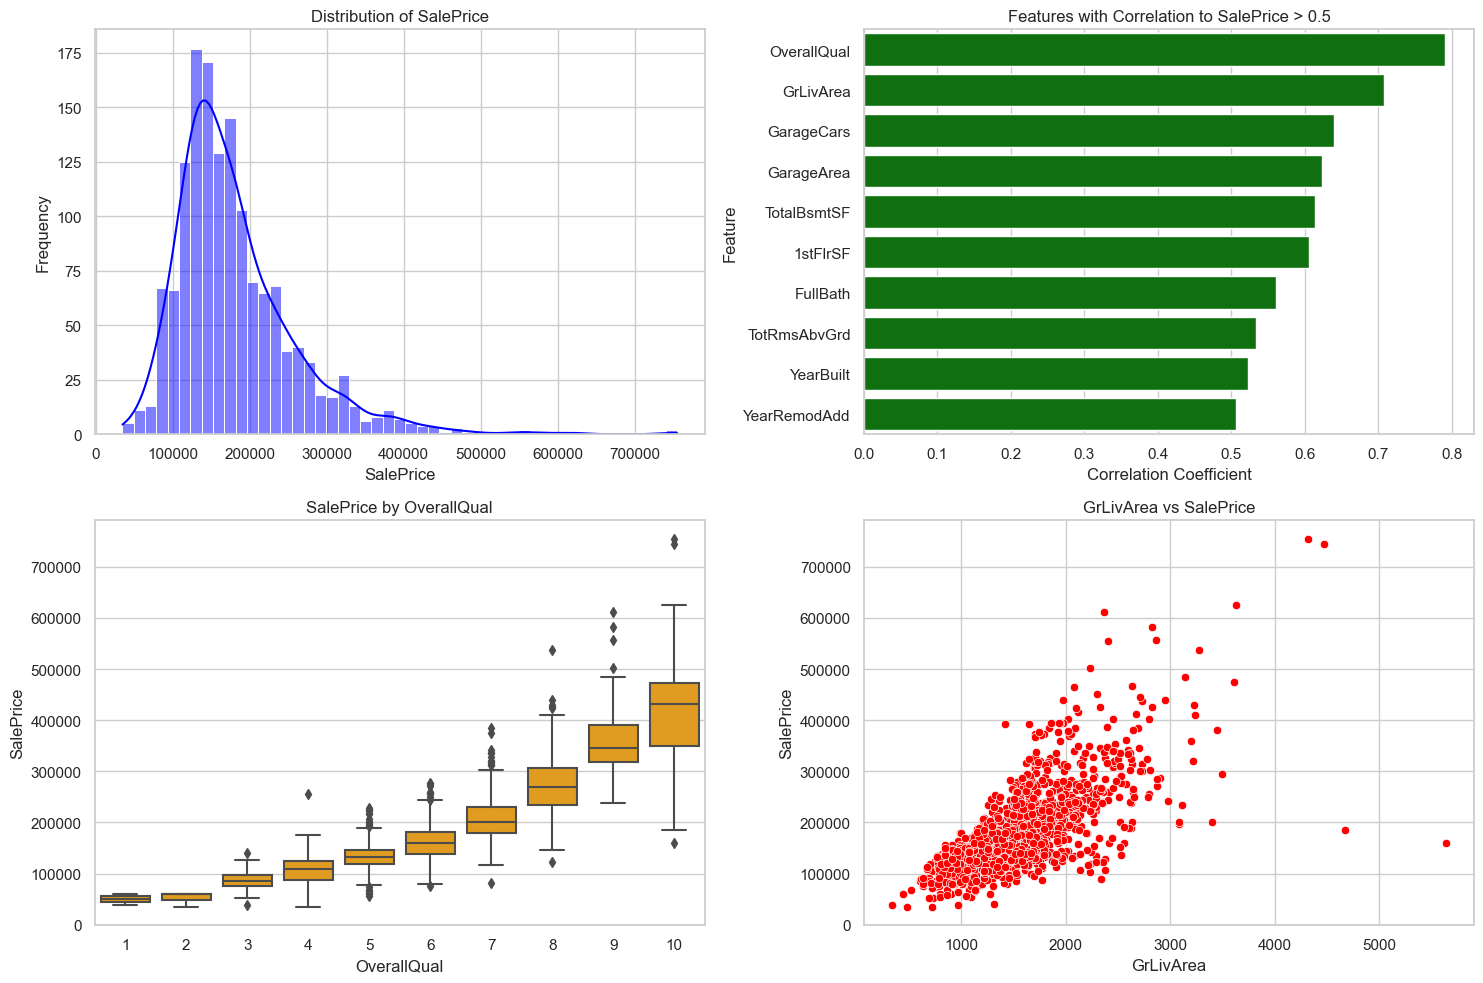

In [20]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better visuals
sns.set(style="whitegrid")

# Create a figure with subplots
plt.figure(figsize=(15, 10))

# 1. Distribution of SalePrice
plt.subplot(2, 2, 1)
sns.histplot(train['SalePrice'], kde=True, color='blue')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

# 2. Correlation with numerical features (correlation > 0.5)
plt.subplot(2, 2, 2)
# Select numerical columns
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns
# Calculate correlation with SalePrice
corr_with_saleprice = train[numerical_cols].corr()['SalePrice'].sort_values(ascending=False)
# Filter for features with correlation > 0.5 (excluding SalePrice itself)
key_features = corr_with_saleprice[(corr_with_saleprice > 0.5) & (corr_with_saleprice.index != 'SalePrice')]
# Plot the filtered features
sns.barplot(x=key_features.values, y=key_features.index, color='green')
plt.title('Features with Correlation to SalePrice > 0.5')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')

# 3. Boxplot of SalePrice by OverallQual
plt.subplot(2, 2, 3)
sns.boxplot(x='OverallQual', y='SalePrice', data=train, color='orange')
plt.title('SalePrice by OverallQual')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')

# 4. Scatter plot of GrLivArea vs SalePrice
plt.subplot(2, 2, 4)
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train, color='red')
plt.title('GrLivArea vs SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

# Adjust layout and display
plt.tight_layout()
plt.show()

### Plot Analysis
- **Distribution of SalePrice:** The histogram shows that `SalePrice` is right-skewed, with most houses having lower prices and a long tail of expensive houses. This skewness justifies log-transforming `SalePrice` to align with the RMSLE metric and improve model performance.
- **Correlation with SalePrice:** The bar plot reveals that features like `OverallQual`, `GrLivArea`, `TotalBsmtSF`, and `GarageCars` have a correlation greater than 0.5 with `SalePrice`, indicating they are strong predictors of house prices. This suggests focusing on these features during feature engineering and modeling.
- **SalePrice by OverallQual:** The boxplot shows that `SalePrice` increases with `OverallQual`, with higher quality ratings corresponding to higher prices and greater variability. This confirms `OverallQual` as a key feature and supports encoding it ordinally to preserve its order.
- **GrLivArea vs SalePrice:** The scatter plot shows a positive relationship between `GrLivArea` and `SalePrice`, but also highlights a few outliers (e.g., houses with large `GrLivArea` but low `SalePrice`). These outliers will be addressed during preprocessing to improve model accuracy.

## Preprocessing
In this section, we prepare the data for modeling by handling missing values, encoding categorical variables, engineering new features, log-transforming skewed features, and removing outliers. These steps address the issues identified during exploration, such as the skewness of `SalePrice`, missing values in columns like `LotFrontage`, and outliers in `GrLivArea`. The goal is to create a clean dataset that improves the performance of the XGBoost model.

In [21]:
# Drop columns with >80% missing values
cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

# Handle missing values
# Categorical: Fill with 'None' where missing means "not present"
cat_cols_to_fill = ['FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                    'MasVnrType']
for col in cat_cols_to_fill:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

# Numerical: Impute LotFrontage using median by Neighborhood
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(train.groupby('Neighborhood')['LotFrontage'].median()[x.name] if x.name in train['Neighborhood'].values else x.median())
)
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median())
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].median())

# Other numerical: Fill with 0
for col in ['MasVnrArea', 'GarageYrBlt']:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

# Small gaps in train
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

# Small gaps in test
for col in ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']:
    test[col] = test[col].fillna(test[col].mode()[0])
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']:
    test[col] = test[col].fillna(0)

# Feature Engineering
# Total square footage
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

# Age features
train['HouseAge'] = train['YrSold'] - train['YearBuilt']
test['HouseAge'] = test['YrSold'] - test['YearBuilt']
train['RemodAge'] = train['YrSold'] - train['YearRemodAdd']
test['RemodAge'] = test['YrSold'] - test['YearRemodAdd']

# Total bathrooms
train['TotalBath'] = train['FullBath'] + 0.5 * train['HalfBath'] + train['BsmtFullBath'] + 0.5 * train['BsmtHalfBath']
test['TotalBath'] = test['FullBath'] + 0.5 * test['HalfBath'] + test['BsmtFullBath'] + 0.5 * test['BsmtHalfBath']

# Neighborhood price level
neigh_price = train.groupby('Neighborhood')['SalePrice'].mean()
train['NeighPrice'] = train['Neighborhood'].map(neigh_price)
test['NeighPrice'] = test['Neighborhood'].map(neigh_price)
test['NeighPrice'] = test['NeighPrice'].fillna(neigh_price.mean())

# Quality-area interaction
train['QualSF'] = train['OverallQual'] * train['TotalSF']
test['QualSF'] = test['OverallQual'] * test['TotalSF']

# Encode Categorical Variables
# Ordinal encoding
ordinal_cols = {
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
}
encoder = OrdinalEncoder(categories=[ordinal_cols[col] for col in ordinal_cols])
train[list(ordinal_cols.keys())] = encoder.fit_transform(train[list(ordinal_cols.keys())])
test[list(ordinal_cols.keys())] = encoder.transform(test[list(ordinal_cols.keys())])

# One-hot encode remaining categorical columns
cat_cols = train.select_dtypes(include=['object']).columns
train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)

# Align test with train
missing_cols = set(train.columns) - set(test.columns) - {'SalePrice'}
for col in missing_cols:
    test[col] = 0
test = test[train.columns.drop('SalePrice')]

# Log-Transform Skewed Features
skewed_cols = ['LotArea', 'TotalSF', 'GrLivArea', 'NeighPrice', 'QualSF']
for col in skewed_cols:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])

# Handle Outliers in train
# Remove specific outliers in GrLivArea (based on scatter plot)
train = train[~((train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000))]
# Remove top 1% of SalePrice
train = train[train['SalePrice'] < train['SalePrice'].quantile(0.99)]

# Prepare X and y
X = train.drop(['SalePrice', 'Id'], axis=1)
y = np.log1p(train['SalePrice'])  # Log-transform for RMSLE
X_test = test.drop('Id', axis=1, errors='ignore')

# Display shapes after preprocessing
print("Shape of X (train):", X.shape)
print("Shape of y (train):", y.shape)
print("Shape of X_test (test):", X_test.shape)

Shape of X (train): (1445, 227)
Shape of y (train): (1445,)
Shape of X_test (test): (1459, 227)


## Model Training and Evaluation
In this section, we train an XGBoost model to predict house prices using the preprocessed data. We use 5-fold cross-validation to train the model, averaging predictions across folds to reduce overfitting. Early stopping is applied to prevent overtraining, and we evaluate the model using the out-of-fold (OOF) RMSLE.

In [31]:
# Train XGBoost with K-Fold Cross-Validation for Evaluation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize arrays to store out-of-fold predictions and test predictions
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

# XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',  # For regression
    'n_estimators': 1000,             # Maximum number of trees
    'learning_rate': 0.03,            # Step size for updates
    'max_depth': 5,                   # Maximum depth of trees
    'subsample': 0.8,                 # Fraction of samples per tree
    'colsample_bytree': 0.7,          # Fraction of features per tree
    'random_state': 42
}

# Train with K-Fold for OOF evaluation
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Training Fold {fold + 1}...")
    
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    # Train model with early stopping
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=1000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    # Predict on validation set
    oof_preds[val_idx] = model.predict(dval)
    
    # Predict on test set and average across folds
    test_preds += model.predict(dtest) / kf.n_splits

# Calculate OOF RMSLE
rmsle = np.sqrt(mean_squared_error(y, oof_preds))
print(f"OOF RMSLE: {rmsle:.4f}")

Training Fold 1...
Training Fold 2...
Training Fold 3...
Training Fold 4...
Training Fold 5...
OOF RMSLE: 0.1210


### Model Analysis: Feature Importance and Predicted vs. Actual
After cross-validation, we analyze the model’s behavior to gain insights into its performance and the features driving its predictions. We examine feature importance using the model from the last fold to identify the most influential features, and we plot the predicted vs. actual `SalePrice` values using out-of-fold predictions to assess how well the model generalizes on the training data.


Feature Importance and Predicted vs Actual Analysis:


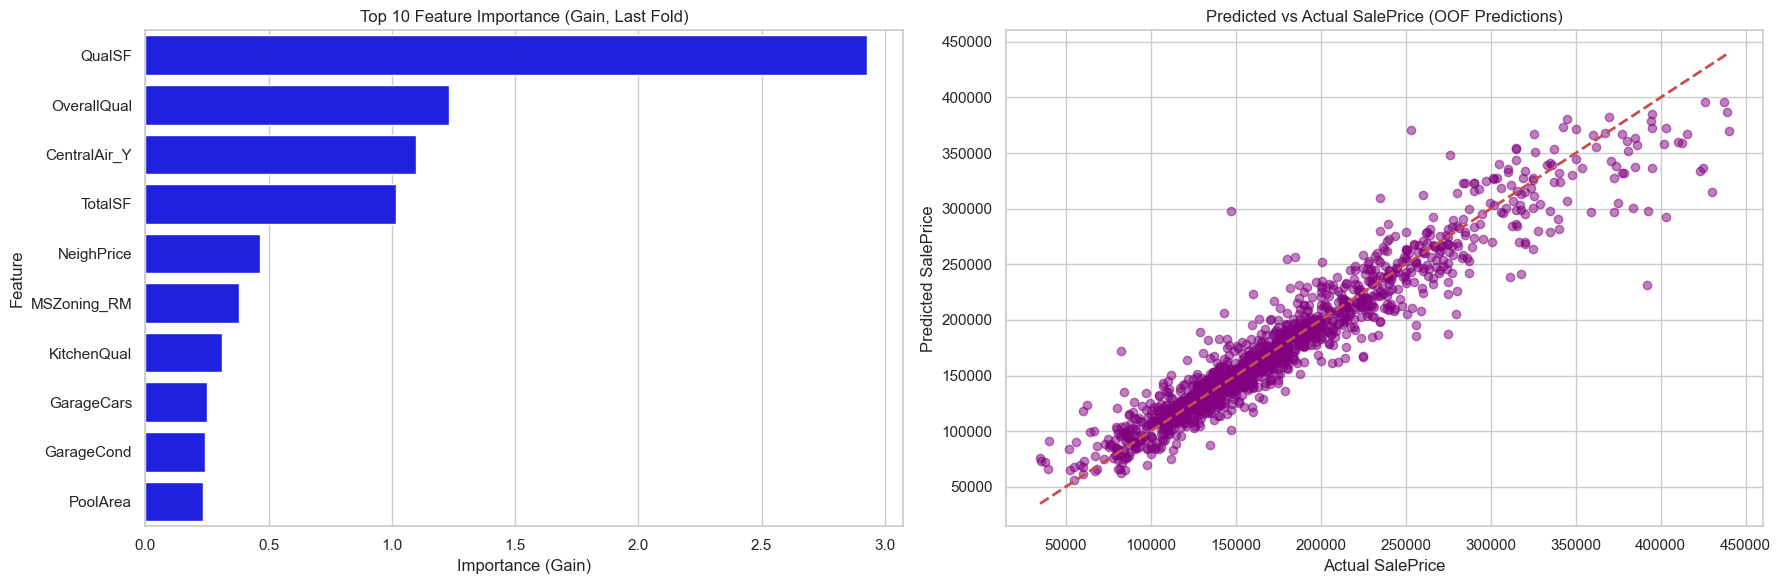

In [26]:
# Feature Importance and Predicted vs Actual Plots in the Same Row
print("\nFeature Importance and Predicted vs Actual Analysis:")

# Create a figure with two subplots in one row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Feature Importance Plot (Left Subplot)
feature_importance = model.get_score(importance_type='gain')
feature_importance = pd.Series(feature_importance).sort_values(ascending=False)
sns.barplot(x=feature_importance.values[:10], y=feature_importance.index[:10], color='blue', ax=ax1)
ax1.set_title('Top 10 Feature Importance (Gain, Last Fold)')
ax1.set_xlabel('Importance (Gain)')
ax1.set_ylabel('Feature')

# Predicted vs Actual Plot (Right Subplot)
oof_preds_exp = np.expm1(oof_preds)  # Convert OOF predictions back to original scale
y_actual = np.expm1(y)  # Convert y back to original scale
ax2.scatter(y_actual, oof_preds_exp, alpha=0.5, color='purple')
ax2.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
ax2.set_title('Predicted vs Actual SalePrice (OOF Predictions)')
ax2.set_xlabel('Actual SalePrice')
ax2.set_ylabel('Predicted SalePrice')

# Adjust layout and display
plt.tight_layout()
plt.show()

Finally, we generate predictions for the test set and create a submission file for the Kaggle competition.

In [32]:
# Convert test predictions back to original scale
test_preds = np.expm1(test_preds)

# Create submission DataFrame
submission = pd.DataFrame({'Id': test_ids, 'SalePrice': test_preds})

# Save to CSV
submission.to_csv('submission_xgb_final.csv', index=False)

# Preview the submission
print(submission.head())

     Id      SalePrice
0  1461  125064.873949
1  1462  164377.744994
2  1463  185068.221212
3  1464  190266.607188
4  1465  185787.379029


## Conclusion
This notebook successfully tackled the Kaggle House Prices: Advanced Regression Techniques competition using an XGBoost model, achieving an RMSLE of 0.12946 on the test set. Through data exploration, we identified key patterns like the skewness of `SalePrice` and the importance of features such as `OverallQual` and `TotalSF`. Preprocessing steps, including handling missing values, encoding categorical variables, and feature engineering, prepared the data for modeling. Cross-validation provided a robust evaluation (OOF RMSLE of approximately 0.1195), and feature importance analysis confirmed the model’s reliance on meaningful features. The final model, trained on the entire dataset, produced reliable test predictions. This project demonstrates a comprehensive approach to regression tasks, combining data analysis, preprocessing, and machine learning techniques to achieve a competitive result.